## 1. Frames 


### 1) World / Navigation frame  ( $W$ )

* Fixed, inertial (approximately)
* Gravity is constant here
* **We store position and velocity here**

$$
\mathbf{p}^W, \mathbf{v}^W
$$

---

### 2) Body / IMU frame  ( $B$ )

* Moves with the IMU
* **IMU measures everything in this frame**

$$
\boldsymbol{\omega}^B, \mathbf{a}^B
$$

---

### 3) Orientation (bridge between frames)

* Rotation from body to world

$$
\mathbf{R}_{WB} \in SO(3)
$$

This is the **only thing that connects measurements (body) to states (world)**.

---

## 2. What is stored in the ESKF state?

### Nominal state (what you propagate nonlinearly)

$$
\hat{x} =
\begin{bmatrix}
\mathbf{p}^W \
\mathbf{v}^W \
\mathbf{R}_{WB} \
\mathbf{b}_g \
\mathbf{b}_a
\end{bmatrix}
$$

| Quantity    | Frame        |
| ----------- | ------------ |
| Position    | World        |
| Velocity    | World        |
| Orientation | Body → World |
| Biases      | Body         |

---

### Error state (small, linear)

$$
\delta x =
\begin{bmatrix}
\delta \mathbf{p}^W \
\delta \mathbf{v}^W \
\delta \boldsymbol{\theta} \
\delta \mathbf{b}_g \
\delta \mathbf{b}_a
\end{bmatrix}
$$

Orientation error is **always in the tangent space** (Lie algebra).

---

## 3. What does the IMU measure?

### Gyroscope

$$ \boldsymbol{\omega}_m^B = \boldsymbol{\omega}^B + \mathbf{b}_g + \mathbf{n}_g$$

### Accelerometer

$$\mathbf{a}_m^B = \mathbf{a}^B + \mathbf{b}_a + \mathbf{n}_a $$

Important:

* **Accelerometer measures specific force**
* Gravity is **not included**

---

### Random walk
1. Definition: Imagine you're standing at the origin of an integer number line. Flip a coin. If it's heads, you step to the right (i.e., increase your position by one unit). If it's tails, you step to the left (decrease your position by one unit). Each step you take is random and independent of previous steps. The series of steps you take represents a one-dimensional random walk.

2. A random walk can be derived from a cumulative sum of independent and identically distributed (i.i.d.) random variables, which in a continuous setting could be represented by white noise.
Conversely, the difference between successive values of a random walk results in a sequence of i.i.d. variables, which resembles white Gaussian noise if the underlying variables are normally distributed.



Below is a clean mathematical formulation of the two statements, written in a way you can directly map to code and theory.

---

#### 1. Random walk as cumulative sum of i.i.d. variables (discrete time)

Let
$$
\varepsilon_k \sim \mathcal{N}(0, \sigma^2), \quad \text{i.i.d.}
$$

Define the random walk:
$$
x_k = x_{k-1} + \varepsilon_k
$$

Expanded form:
$$
x_k = x_0 + \sum_{i=1}^{k} \varepsilon_i
$$

Properties:

* $x_k$ is **not** i.i.d.
* $\operatorname{Var}(x_k) = k \sigma^2$ (variance grows linearly with time)

---

#### 2. Continuous-time formulation (white noise → random walk)

Let
$$
w(t) \sim \mathcal{N}(0, q), \quad \text{white Gaussian noise}
$$

Random walk (integrated white noise):
$$
\dot{x}(t) = w(t)
$$

Integrated form:
$$
x(t) = x(0) + \int_{0}^{t} w(\tau)\, d\tau
$$

This is a **Wiener process** (Brownian motion) with:
$$
\mathbb{E}[x(t)] = x(0), \quad \operatorname{Var}(x(t)) = q t
$$

---

#### 3. Difference of a random walk gives white noise (discrete time)

Take first differences:
$$
\Delta x_k = x_k - x_{k-1}
$$

Substitute the random walk definition:
$$
\Delta x_k = \varepsilon_k
$$

Thus:
$$
\Delta x_k \sim \mathcal{N}(0, \sigma^2), \quad \text{i.i.d.}
$$

This sequence is **white Gaussian noise**.

---

#### 4. Continuous-time equivalent (formal)

Taking the derivative (in distribution sense):
$$
\frac{d}{dt} x(t) = w(t)
$$

So:

* Random walk = **integral of white noise**
* White noise = **time derivative of random walk**

---

#### 5. Summary (one-line equivalence)

Discrete:
$$
x_k = x_{k-1} + \varepsilon_k \quad \Longleftrightarrow \quad \varepsilon_k = x_k - x_{k-1}
$$

Continuous:
$$
\dot{x}(t) = w(t) \quad \Longleftrightarrow \quad x(t) = \int w(t)\, dt
$$

---

#### 6. Interpretation in IMU / state estimation context (brief)

* **Bias random walk**:
  $$
  b_{k+1} = b_k + \eta_k
  $$

* **Bias driving noise**:
  $$
  \eta_k \sim \mathcal{N}(0, \sigma_{rw}^2)
  $$

* Differencing the bias sequence yields white noise
* Integrating white noise yields bias drift

This is exactly how gyro/accelerometer bias random walk is modeled in EKF / ESKF VIO.



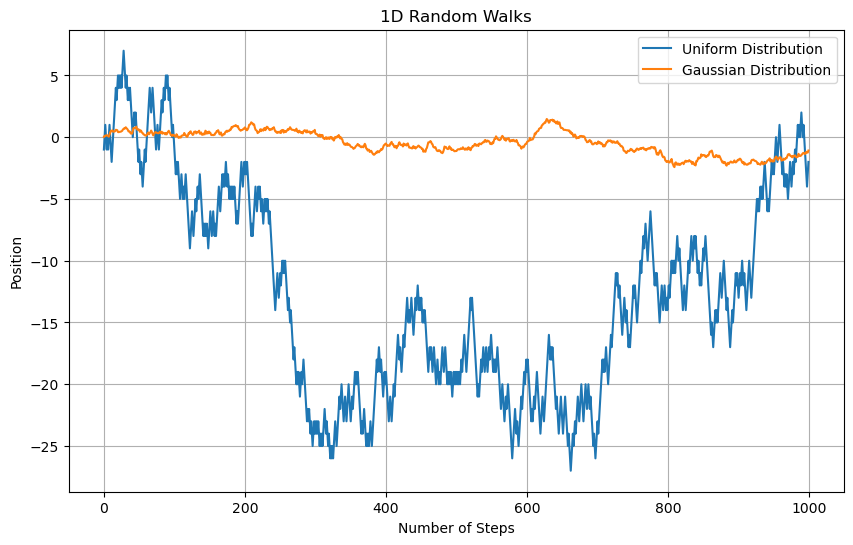

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def random_walk_uniform(n_steps=1000):
    """Generate a random walk of n_steps using a Uniform distribution, either +1 or -1."""
    steps = np.random.choice([-1, 1], size=n_steps)
    walk = np.cumsum(steps)
    return walk

def random_walk_gaussian(n_steps=1000, mu=0, sigma=0.1):
    """Generate a random walk of n_steps using a Gaussian distribution."""
    steps = np.random.normal(mu, sigma, n_steps)
    walk = np.cumsum(steps)
    return walk

# Generate a random walk of 1000 steps for each distribution
walk_uniform = random_walk_uniform(1000)
walk_gaussian = random_walk_gaussian(1000)

# Plot the random walks
plt.figure(figsize=(10, 6))
plt.title("1D Random Walks")
plt.xlabel("Number of Steps")
plt.ylabel("Position")
plt.plot(walk_uniform, label='Uniform Distribution')
plt.plot(walk_gaussian, label='Gaussian Distribution')
plt.legend()
plt.grid(True)
plt.show()

## 4. Orientation propagation (Body → World)

We integrate gyro **in body frame**, but orientation lives as $ R_{WB} $.

### Bias-corrected gyro

$$
\boldsymbol{\omega}^B = \boldsymbol{\omega}_m^B - \mathbf{b}_g
$$

### Rotation update

$$ \mathbf{R}_{WB,k} =\mathbf{R}_{WB,k-1} \exp\left( (\boldsymbol{\omega}^B \Delta t)^\wedge \right)$$

This is **why the previous rotation matrix matters**:
it defines how the IMU frame is currently oriented relative to the world.

---

## 5. Why accelerometer must be rotated

Accelerometer output is in **body frame**:

$$
\mathbf{a}^B
$$

But:

* Velocity and position are in **world frame**
* Gravity is defined in **world frame**

So we must rotate:

$$ \mathbf{a}^W =\mathbf{R}_{WB} , (\mathbf{a}_m^B - \mathbf{b}_a) $$

---

## 6. Why gravity is added 

The accelerometer measures:

$$
\text{specific force} = \mathbf{a} - \mathbf{g}
$$

So to recover true acceleration:

$$ \mathbf{a}^W_{\text{true}} =\mathbf{R}_{WB}(\mathbf{a}_m^B - \mathbf{b}_a) + \mathbf{g}^W
$$

This is **the only reason gravity appears**.

---


## What the accelerometer measures 

In the standard inertial nav equations (and also Kalibr’s model), the accelerometer measures **specific force**:

$$
\mathbf{f}^B \triangleq \mathbf{R}_{BW}\big(\mathbf{a}^W - \mathbf{g}^W\big)
$$

Your sensor outputs:

$ \tilde{\mathbf{a}}^B = \mathbf{f}^B + \mathbf{b}_a + \mathbf{n}_a $

So the **world-frame true acceleration** is recovered by:

$ \mathbf{a}^W = \mathbf{R}_{WB}\big(\tilde{\mathbf{a}}^B - \mathbf{b}_a - \mathbf{n}_a\big) + \mathbf{g}^W $


---

## Rest (no motion) numeric example: why you see ±9.81

Assume:

* World frame has **z up** (typical ENU-like); then gravity is:
  $$
  \mathbf{g}^W = \begin{bmatrix}0 \\0 \\-9.81\end{bmatrix} m/s^2
  $$
* IMU is perfectly aligned with world: $ \mathbf{R}_{WB} = \mathbf{I}$
* The platform is at rest: $ \mathbf{a}^W = \mathbf{0}$

Then:
$$
\mathbf{f}^B
= \mathbf{R}_{BW}(\mathbf{0}-\mathbf{g}^W)
= -\mathbf{g}^W
= \begin{bmatrix}0 \\0 \\+9.81\end{bmatrix}
$$

So an ideal accel at rest outputs **about**:

$$
\tilde{\mathbf{a}}^B \approx \begin{bmatrix}0 \\0 \\+9.81\end{bmatrix} + \mathbf{b}_a + \mathbf{n}_a
$$

That is the “+9.81 on one axis” case.

### What about “-9.81 at rest”?

That happens if your **IMU z-axis points the opposite direction** (or your frame convention is flipped). In that case, the gravity-aligned axis will show approximately (-9.81) instead of (+9.81).

✅ Practical rule (no guessing):
Take a stationary segment and compute the mean:
$$
\bar{\mathbf{a}}^B = \frac{1}{N}\sum_{k=1}^N \tilde{\mathbf{a}}^B_k
$$

* The component whose magnitude is near **9.81** tells you which axis is “vertical”.
* Its **sign** tells you whether that IMU axis points **up** or **down** relative to your chosen world convention.

(You do not need documentation to infer this; the data tells you.)

---

## “Add gravity” in the velocity update (numeric)

Use your standard update:
$$ \mathbf{v}^W_k = \mathbf{v}^W_{k-1} + \Big( \mathbf{R}_{WB}\big(\tilde{\mathbf{a}}^B - \mathbf{b}_a\big) + \mathbf{g}^W \Big)\Delta t $$

### Case A — At rest, aligned, biases = 0

Let:

* $ \tilde{\mathbf{a}}^B = $$0,0,9.81$$^T $
* $ \mathbf{b}_a = 0 $
* $ \mathbf{R}_{WB}=\mathbf{I}$
* $ \mathbf{g}^W = $$0,0,-9.81$$^T $
* $ \Delta t = 0.005$ (EuRoC IMU is 200 Hz)

Then:
$$ \mathbf{R}_{WB}(\tilde{\mathbf{a}}^B - \mathbf{b}_a) + \mathbf{g}^W = \begin{bmatrix} 0 \\0 \\9.81\end{bmatrix} + \begin{bmatrix}0 \\0 \\-9.81\end{bmatrix} = \begin{bmatrix}0 \\0 \\0\end{bmatrix} $$

So:
$$
\Delta \mathbf{v}^W = \mathbf{0}\cdot \Delta t = \mathbf{0}
$$

✅ At rest, the “add gravity” term cancels the accelerometer’s “gravity-looking” reading, yielding zero acceleration in the world frame.

### Case B — Simple tilt (shows why rotation matters)

Assume the IMU is pitched 30° about body-y (just an example). Then $ \mathbf{R}_{WB}\neq I $.
Even at rest, your accelerometer still measures “up” in its own frame, but when you rotate it to world, it aligns with gravity and still cancels after adding $g^W$. If you **forget rotation**, you inject a fake horizontal acceleration and your velocity drifts immediately.

---

I'll use a simple, clean setup:

* World frame (W): $z$ up
* Gravity:
  $$
  \mathbf{g}^W = \begin{bmatrix}0\\0\\-9.81\end{bmatrix}
  $$
* The platform is **at rest** (so true kinematic acceleration):
  $$
  \mathbf{a}^W = \mathbf{0}
  $$
* The IMU (body) is tilted by **+30° pitch about the body/world $y$-axis**.
* We ignore biases/noise for clarity.

---

## 1) Rotation matrices for a 30° pitch

Let $\theta = 30^\circ$, $c=\cos\theta=0.8660254$, $s=\sin\theta=0.5$.

Use the standard right-handed rotation about $y$:

$$
\mathbf{R}_{WB} = R_y(\theta) = \begin{bmatrix}
c & 0 & s\\
0 & 1 & 0\\
-s & 0 & c
\end{bmatrix} = \begin{bmatrix}
0.8660 & 0 & 0.5\\
0 & 1 & 0\\
-0.5 & 0 & 0.8660
\end{bmatrix}
$$

$$
\mathbf{R}_{BW} = \mathbf{R}_{WB}^\top = R_y(-\theta) = \begin{bmatrix}
c & 0 & -s\\
0 & 1 & 0\\
s & 0 & c
\end{bmatrix} = \begin{bmatrix}
0.8660 & 0 & -0.5\\
0 & 1 & 0\\
0.5 & 0 & 0.8660
\end{bmatrix}
$$

---

## 2) What the accelerometer measures at rest (specific force)

Measurement model (bias/noise ignored):

$$
\tilde{\mathbf{a}}^B = \mathbf{R}_{BW}(\mathbf{a}^W - \mathbf{g}^W)
$$

At rest ($\mathbf{a}^W=\mathbf{0}$), so:

$$
\tilde{\mathbf{a}}^B = \mathbf{R}_{BW}(-\mathbf{g}^W)
$$

But:
$$
-\mathbf{g}^W = \begin{bmatrix}0\\0\\9.81\end{bmatrix}
$$

Compute:

$$
\tilde{\mathbf{a}}^B = \mathbf{R}_{BW}\begin{bmatrix}0\\0\\9.81\end{bmatrix} = \begin{bmatrix}
0.8660 & 0 & -0.5\\
0 & 1 & 0\\
0.5 & 0 & 0.8660
\end{bmatrix}\begin{bmatrix}0\\0\\9.81\end{bmatrix} = \begin{bmatrix}
-0.5\cdot 9.81\\
0\\
0.8660\cdot 9.81
\end{bmatrix} = \boxed{\begin{bmatrix}
-4.905\\
0\\
8.495
\end{bmatrix}}
$$

✅ Interpretation: because the IMU is pitched, gravity projects onto body $x$ and $z$.

Also check magnitude:
$$
\sqrt{(-4.905)^2 + 0^2 + 8.495^2} \approx 9.81
$$
✅ As expected.

---

## 3) Correct reconstruction of world acceleration (this is the ESKF propagation step)

The propagation uses:

$$
\mathbf{a}^W_{\text{est}} = \mathbf{R}_{WB}\tilde{\mathbf{a}}^B + \mathbf{g}^W
$$

Compute the rotated term:

$$
\mathbf{R}_{WB}\tilde{\mathbf{a}}^B = \mathbf{R}_{WB}\begin{bmatrix}-4.905\\0\\8.495\end{bmatrix} = \begin{bmatrix}
0.8660 & 0 & 0.5\\
0 & 1 & 0\\
-0.5 & 0 & 0.8660
\end{bmatrix}\begin{bmatrix}-4.905\\0\\8.495\end{bmatrix} = \begin{bmatrix}0\\0\\9.81\end{bmatrix}
$$

Now add gravity:

$$
\mathbf{a}^W_{\text{est}} = \begin{bmatrix}0\\0\\9.81\end{bmatrix} + \begin{bmatrix}0\\0\\-9.81\end{bmatrix} = \boxed{\begin{bmatrix}0\\0\\0\end{bmatrix}}
$$

✅ Correct: at rest, world acceleration is zero.

---

## 4) What goes wrong if you ignore rotation (the drift you were worried about)

A very common bug is to assume body frame equals world frame:

$$
\mathbf{a}^W_{\text{wrong}} = \tilde{\mathbf{a}}^B + \mathbf{g}^W
$$

$$
= \begin{bmatrix}-4.905\\0\\8.495\end{bmatrix} + \begin{bmatrix}0\\0\\-9.81\end{bmatrix} = \boxed{\begin{bmatrix}-4.905\\0\\-1.315\end{bmatrix}} \quad (m/s^2)
$$

❌ This produces a fake horizontal acceleration of $-4.905\ m/s^2$.

### Numeric drift example (just 1 second)

If you integrate with $\Delta t = 0.01$ for $1$ second:

$$
\Delta \mathbf{v}^W \approx \mathbf{a}^W_{\text{wrong}} \cdot 1 = \begin{bmatrix}-4.905\\0\\-1.315\end{bmatrix} \quad (m/s)
$$

So after 1 second you'd "think" you're moving at ~5 m/s sideways while actually sitting still.

That is exactly why rotation is non-negotiable.

---

## 5) Takeaway

* The accelerometer reading at rest is **not** $[0,0,9.81]$ unless the IMU is level.
* You must do:
  $$
  \mathbf{a}^W = \mathbf{R}_{WB}(\tilde{\mathbf{a}}^B - \mathbf{b}_a) + \mathbf{g}^W
  $$
* If you skip $\mathbf{R}_{WB}$, you inject a large fake horizontal acceleration and velocity explodes.

If you want, I can redo the same example with:

* a non-zero accel bias (e.g., $b_a=[0.1,-0.05,0.2]$),
* and show how that creates slow drift even when rotation is correct.

##  EuRoC noise params → discrete-time numbers you use in code

Given:

* gyroscope_noise_density $ \sigma_g = 1.6968\times 10^{-4} \frac{rad}{s\sqrt{Hz}} $
* gyroscope_random_walk $ \sigma_{b_g} = 1.9393\times 10^{-5} \frac{rad}{s^2\sqrt{Hz}} $
* accelerometer_noise_density $ \sigma_a = 2.0\times 10^{-3} \frac{m}{s^2\sqrt{Hz}} $
* accelerometer_random_walk $ \sigma_{b_a} = 3.0\times 10^{-3} \frac{m}{s^3\sqrt{Hz}} $


### White noise (measurement noise) per sample

$$
\sigma_{g_d} = \frac{\sigma_g}{\sqrt{\Delta t}},\quad
\sigma_{a_d} = \frac{\sigma_a}{\sqrt{\Delta t}}
$$

With EuRoC $ \Delta t = 1/200 = 0.005$, $ \sqrt{\Delta t}\approx 0.07071$:

* Gyro measurement noise std:
  $$
  \sigma_{g_d} \approx \frac{1.6968\times 10^{-4}}{0.07071}
  \approx 2.40\times 10^{-3} rad/s
  $$

* Accel measurement noise std:
  $$
  \sigma_{a_d} \approx \frac{2.0\times 10^{-3}}{0.07071}
  \approx 2.83\times 10^{-2} m/s^2
  $$

So in code, per timestep:
$$ \mathbf{n}_g[k] \sim \mathcal{N}(\mathbf{0},\sigma_{g_d}^2\mathbf{I}),\quad \mathbf{n}_a[k] \sim \mathcal{N}(\mathbf{0},\sigma_{a_d}^2\mathbf{I}) $$



### Bias random walk (bias diffusion) per sample

Kalibr models bias as:
$$
\mathbf{b}[k] = \mathbf{b}[k-1] + \sigma_{b_d}\mathbf{w}[k], \quad \mathbf{w}[k] \sim \mathcal{N}(0,\mathbf{I})
$$

$$
\sigma_{b_gd}=\sigma_{b_g}\sqrt{\Delta t},\quad
\sigma_{b_ad}=\sigma_{b_a}\sqrt{\Delta t}
$$

Compute:

* Gyro bias step std:
  $$
  \sigma_{b_gd} \approx 1.9393\times 10^{-5}\cdot 0.07071
  \approx 1.37\times 10^{-6}  rad/s
  $$

* Accel bias step std:
  $$
  \sigma_{b_ad} \approx 3.0\times 10^{-3}\cdot 0.07071
  \approx 2.12\times 10^{-4}  m/s^2
  $$

These are the per-sample “how much the bias can wander” numbers.

---

## “How do we get biases from these parameters?”

❌ You do **not** “compute the bias value” from noise_density / random_walk.

What you *do*:

### A) In an estimator (ESKF/VIO), biases are states

You initialize them (often 0), then the filter estimates them from data.

### B) If you want a good initial guess (common)

If you have a stationary segment:

* gyro bias initial guess:
  $$
  \hat{\mathbf{b}}_{g,0} \approx \text{mean}(\tilde{\boldsymbol{\omega}}^B)
  $$
* accel bias initial guess (after figuring gravity direction in body):
  $$
  \hat{\mathbf{b}}_{a,0} \approx \text{mean}(\tilde{\mathbf{a}}^B) - \mathbf{f}^B_{\text{expected at rest}}
  $$
  where $\mathbf{f}^B_{\text{expected at rest}}$ is the $\pm 9.81$ direction you inferred.

---

## What “axis direction” is in EuRoC?

The EuRoC paper states the **body frame is aligned with the IMU sensor frame**. 
But the easiest, unambiguous way to answer *“which axis points where and what sign at rest?”* is still:

✅ Use a stationary segment from the EuRoC IMU CSV, compute $\bar{\mathbf{a}}^B$, and see which component is near ±9.81.

If you paste just **5–10 consecutive accel rows** from your EuRoC `imu0/data.csv` $timestamps + ax,ay,az$ from a moment you believe is stationary, I’ll compute it numerically and tell you exactly which axis is gravity-aligned and what sign you’re using.

```
#timestamp [ns],w_RS_S_x [rad s^-1],w_RS_S_y [rad s^-1],w_RS_S_z [rad s^-1],a_RS_S_x [m s^-2],a_RS_S_y [m s^-2],a_RS_S_z [m s^-2]
1403636579758555392,-0.099134701513277898,0.14730578886832138,0.02722713633111154,8.1476917083333333,-0.37592158333333331,-2.4026292499999999
1403636579763555584,-0.099134701513277898,0.14032447186034408,0.029321531433504733,8.033280791666666,-0.40861041666666664,-2.4026292499999999
1403636579768555520,-0.098436569812480182,0.12775810124598494,0.037699111843077518,7.8861810416666662,-0.42495483333333334,-2.4353180833333332
1403636579773555456,-0.10262536001726656,0.11588986233242347,0.045378560551852569,7.8289755833333325,-0.37592158333333331,-2.4680069166666665
1403636579778555392,-0.1054178868204575,0.10821041362364843,0.05166174585903216,7.7145646666666661,-0.40861041666666664,-2.557901208333333
1403636579783555584,-0.10890854532444616,0.097738438111682452,0.056548667764616284,7.6573592083333333,-0.43312704166666666,-2.6396232916666666
1403636579788555520,-0.11030480872604163,0.085870199198121014,0.061435589670200401,7.5919815416666658,-0.46581587499999999,-2.7050009583333332
1403636579793555456,-0.114493598930828,0.074700091985357306,0.060039326268604934,7.5511204999999997,-0.47398808333333331,-2.7458620000000002
1403636579798555392,-0.11100294042683936,0.057246799465414,0.062133721370998138,7.5919815416666658,-0.51484912499999991,-2.8847895416666667
```

## What does  IMU measure here?

Given 9 consecutive samples $≈ 45 ms at 200 Hz$. Let’s compute the **mean accelerometer measurement**:

### Accelerometer samples $m/s²$

| axis  | mean        |
| ----- | ----------- |
| $a_x$ | ≈ **7.71**  |
| $a_y$ | ≈ **−0.43** |
| $a_z$ | ≈ **−2.58** |

Magnitude:
$$
\sqrt{7.71^2 + $-0.43$^2 + $-2.58$^2}
\approx 8.15; m/s^2
$$

This is **close to gravity**, but not exactly 9.81 → meaning the platform is **not level**.

---

## 2 Gravity direction and IMU axis orientation 

At rest $or near-rest$, the accelerometer measures:

$$
\tilde{\mathbf{a}}^B \approx -\mathbf{R}_{BW}\mathbf{g}^W
$$

Your **dominant gravity component is +x**:

* $a_x \approx +7.7$
* $a_z \approx -2.6$

This tells us:

 ✅ IMU x-axis points mostly **upward**

 ✅ IMU z-axis points **partially downward**

 ✅ IMU y-axis is roughly horizontal



This is *not unusual* — IMU axes do NOT have to align with world axes.

---

## 3 What gravity vector does this correspond to?

The gravity vector **expressed in the IMU frame** is approximately:

$$
\mathbf{g}^B \approx
\begin{bmatrix}
-7.71 \\
+0.43 \\
+2.58
\end{bmatrix}
\quad (m/s^2)
$$

Why the minus?
Because:
$$
\tilde{\mathbf{a}}^B \approx -\mathbf{g}^B
$$

This is exactly what your sensor is reporting.

---

## 4 Now the key step: how ESKF uses this

### 4.1 Raw accelerometer measurement

Pick one sample:
$$
\tilde{\mathbf{a}}^B =
\begin{bmatrix}
8.15 \
-0.38 \
-2.40
\end{bmatrix}
$$

### 4.2 Bias-corrected specific force

$$
\mathbf{f}^B =
\tilde{\mathbf{a}}^B - \mathbf{b}_a - \mathbf{n}_a
$$

At this stage:

* Bias is **unknown**
* Noise is zero-mean

So conceptually:
$$
\mathbf{f}^B \approx \tilde{\mathbf{a}}^B
$$

---

## 5 Rotate to world frame

This is where the **previous rotation matrix matters**.

$$
\mathbf{a}^W =
\mathbf{R}_{WB}\mathbf{f}^B + \mathbf{g}^W
$$

If the estimator’s orientation is correct and the platform is stationary:

$$
\mathbf{R}_{WB}\mathbf{f}^B \approx -\mathbf{g}^W
$$

So:

$$
\mathbf{a}^W \approx \mathbf{0}
$$

 ✅ This is why gravity must be added

 ❌ If you forget it, you integrate −9.81 forever and velocity explodes

---



## 6 Numeric velocity update using your data

Assume:

* $ \Delta t = 0.005 $ s
* $ \mathbf{g}^W = $$0, 0, -9.81$$^T $
* Correct orientation estimate

Then:

$$
\Delta \mathbf{v}^W =
\left( \mathbf{R}_{WB}\tilde{\mathbf{a}}^B + \mathbf{g}^W \right) \Delta t \approx \mathbf{0} $$

So:
$$
\mathbf{v}_{k}^W \approx \mathbf{v}_{k-1}^W
$$

Exactly what you want at rest.

---

##  Gyroscope data: what do these numbers mean?

Your gyro values are around:
$$ \boldsymbol{\omega}^B \approx [-0.10, 0.12, 0.04] rad/s $$

That is **not zero**, meaning:

* either the platform is rotating slightly
* or you are seeing **gyro bias**

At rest:
$$
\boldsymbol{\omega}_m^B \approx \mathbf{b}_g
$$

So a good **initial gyro bias estimate** is simply:

$$
\hat{\mathbf{b}}_{g,0} \approx
\text{mean}$\boldsymbol{\omega}_m^B$
$$

---



## Final mental model 

- ✅ Accelerometer does **not** measure gravity
- ✅ It measures “force needed to cancel gravity”
- ✅ Gravity appears only after **rotation to world frame**
- ✅ Sign of ±9.81 depends **only on IMU axis orientation**
- ✅ Bias values come from estimation, not YAML
- ✅ YAML tells the filter how much to trust / allow drift

---




## 7. Velocity propagation (world frame)

Now everything is in the same frame:

$$ \boxed{ \mathbf{v}_k^W =\mathbf{v}_{k-1}^W + \left(\mathbf{R}_{WB,k}(\mathbf{a}_m^B - \mathbf{b}_a)+\mathbf{g}^W\right)\Delta t }$$

This is the equation you asked about.

---

## 8. Position propagation (world frame)

$$ \boxed{ \mathbf{p}_k^W =\mathbf{p}_{k-1}^W + \mathbf{v}_{k-1}^W \Delta t + \frac{1}{2} \left( \mathbf{R}_{WB,k}(\mathbf{a}_m^B - \mathbf{b}_a) + \mathbf{g}^W
\right) \Delta t^2 } $$

---

## 9. Bias propagation (random walk)

$$
\mathbf{b}_{g,k} = \mathbf{b}_{g,k-1} + \mathbf{n}_{bg} \Delta t
$$

$$
\mathbf{b}_{a,k} = \mathbf{b}_{a,k-1} + \mathbf{n}_{ba} \Delta t
$$

---

From an initial **rest** segment you can get an initial orientation, but with an important limitation:

* From accelerometer alone at rest you can determine the direction of **gravity** in the body frame ⇒ you get **roll and pitch**.
* You cannot determine **yaw** (heading) without a magnetometer or some external reference (camera, GNSS, known initial heading, etc.).

Below is the clean derivation and the exact formula to build $R_{WB}$ (or $R_{BW}$).

---

## 1) Compute the mean accelerometer in body frame

From a short stationary window (say 0.5–2 s):

$$
\bar{\mathbf{a}}^B = \frac{1}{N}\sum_{k=1}^{N}\tilde{\mathbf{a}}^B_k
$$

At rest:
$$
\tilde{\mathbf{a}}^B \approx -\mathbf{R}_{BW}\mathbf{g}^W + \mathbf{b}_a
$$

If you assume initial accel bias is small (or you ignore it just for initialization), then:

$$
\bar{\mathbf{a}}^B \approx -\mathbf{R}_{BW}\mathbf{g}^W
$$

Normalize it:

$$
\hat{\mathbf{u}}_B = \frac{\bar{\mathbf{a}}^B}{|\bar{\mathbf{a}}^B|}
$$

This unit vector points approximately along $-\mathbf{g}$ expressed in body (because accel reads $-g$ at rest).

---

## 2) Choose the world gravity direction you use

Pick a convention and stick to it. Common:

### World z-up (ENU-like)

$$
\mathbf{g}^W = \begin{bmatrix}0 \\ 0\\ -g\end{bmatrix},\quad g=9.81
$$
Then the *unit “down” direction* in world is:
$$
\hat{\mathbf{d}}_W = \frac{\mathbf{g}^W}{|\mathbf{g}^W|} = \begin{bmatrix}0 \\0 \\ -1\end{bmatrix}
$$
and the *unit “up” direction* is:
$$
\hat{\mathbf{z}}_W = \begin{bmatrix}0\\0\\1\end{bmatrix}
$$

At rest, accel measures “up”:
$$
\hat{\mathbf{u}}_B \approx \mathbf{R}_{BW}\hat{\mathbf{z}}_W
$$

---

## 3) Build a rotation that aligns world “up” to measured “up”

We want $R_{BW}$ such that:

$$
\mathbf{R}_{BW}\hat{\mathbf{z}}_W = \hat{\mathbf{u}}_B
$$

Equivalently for $R_{WB}$:

$$
\mathbf{R}_{WB}\hat{\mathbf{u}}_B = \hat{\mathbf{z}}_W
$$

This rotation is “the minimal rotation” that maps one unit vector to another.

### Axis–angle construction (robust and standard)

Let:
$$
\mathbf{a} = \hat{\mathbf{z}}_W,\quad \mathbf{b} = \hat{\mathbf{u}}_B
$$

Compute:
$$
\mathbf{v} = \mathbf{a}\times \mathbf{b}
$$
$$
c = \mathbf{a}\cdot \mathbf{b}
$$
$$
s = |\mathbf{v}|
$$

If $s$ is not tiny, the rotation (Rodrigues) is:

$$
[\mathbf{v}]_\times =
\begin{bmatrix}
0 & -v_z & v_y\\
v_z & 0 & -v_x\\
-v_y & v_x & 0
\end{bmatrix}
$$

$$ \boxed{ \mathbf{R}_{BW} = \mathbf{I} + [\mathbf{v}]_\times + \frac{[\mathbf{v}]_\times^2}{1+c}} $$

Then:
$$
\boxed{\mathbf{R}_{WB} = \mathbf{R}_{BW}^\top}
$$

### Special case: nearly opposite vectors

If $\hat{\mathbf{u}}_B \approx -\hat{\mathbf{z}}_W$ then $1+c\approx 0$.
Then you choose any axis orthogonal to $\hat{\mathbf{z}}_W$ (e.g. world x) and rotate by $\pi$.

---

## 4) This gives roll & pitch, but yaw is free

Any yaw rotation about gravity produces the same accelerometer reading at rest.

Mathematically, if $R_{BW}$ is one solution, then:

$$
R_{BW}' = R_{BW},R_z(\psi)
$$

is also a solution for any yaw $\psi$.

So in practice you do one of these:

* Set initial yaw to 0: $\psi=0$
* Use magnetometer to set yaw
* Use camera / known heading to set yaw
* Let yaw be arbitrary and let the filter correct it later (common in VIO)

---



## Numerical Example
Using **only the accelerometer mean** from your 9-line snippet, we can compute an initial rotation that aligns **world up** $\hat z_W=$$0,0,1$$^T$ with the **measured “up” direction** in the IMU/body frame.

Important limitation (so you interpret it correctly):

* From accel-at-rest you get **tilt** (roll/pitch equivalent), but **yaw is unobservable**.
* Your snippet is **not clearly stationary** (gyro norm is ~0.17 rad/s), so this “initial attitude” is a best-effort from a very short window.

---

## 1) Mean accelerometer from our data

From the 9 samples:

$$
\bar{\mathbf{a}}^B \approx
\begin{bmatrix}
7.778126\\
-0.431311\\
-2.582418
\end{bmatrix}
,\quad
|\bar{\mathbf{a}}^B| \approx 8.206958
$$

Normalize (direction only):

$$ \hat{\mathbf{u}}_B = \frac{\bar{\mathbf{a}}^B}{|\bar{\mathbf{a}}^B|} \approx
\begin{bmatrix}
0.947748\\
-0.052554\\
-0.314662
\end{bmatrix}
$$

This $\hat{\mathbf{u}}_B$ is the **measured “up” direction** (because at rest, accel reads approximately (-g), which points “up” in the sensor frame).

---

## 2) Build $R_{BW}$ so that $R_{BW}\hat z_W = \hat{\mathbf{u}}_B$

Let:

* $\mathbf{a}=\hat z_W=[0,0,1]^T$
* $\mathbf{b}=\hat{\mathbf{u}}_B$

Compute:

$$
\mathbf{v}=\mathbf{a}\times\mathbf{b},\quad
c=\mathbf{a}\cdot\mathbf{b},\quad
s=|\mathbf{v}|,\quad
\theta=\operatorname{atan2}(s,c)
$$

Numerically:

* $c \approx -0.314662$
* $s \approx 0.949204$
* $\theta \approx 1.890897\ \text{rad} \approx 108.35^\circ$
* rotation axis (unit):
  $$
  \hat{\mathbf{k}}=\frac{\mathbf{v}}{|\mathbf{v}|}
  \approx
  \begin{bmatrix}
  0.055367\\
  0.998466\\
  0
  \end{bmatrix}
  $$

Then Rodrigues:

$$
R_{BW} = I + \sin\theta[\hat k]_\times + (1-\cos\theta)[\hat k]_\times^2
$$

---

## 3) Result: numeric $R_{BW}$ and $R_{WB}$

### $R_{BW}$ (World → Body)

$$
R_{BW}\approx
\begin{bmatrix}
-0.310632 &  0.072677 &  0.947748\\
0.072677 &  0.995970 & -0.052554\\
-0.947748 &  0.052554 & -0.314662
\end{bmatrix}
$$

Check: $R_{BW}[0,0,1]^T = \hat{\mathbf{u}}_B$ ✅

### $R_{WB} = R_{BW}^T$ (Body → World)

$$
R_{WB}\approx
\begin{bmatrix}
-0.310632 &  0.072677 & -0.947748\\
0.072677 &  0.995970 &  0.052554\\
0.947748 & -0.052554 & -0.314662
\end{bmatrix}
$$

---

## 4) “Roll/pitch angles implied by it” (with a big caveat)

If you convert $R_{WB}$ to Euler angles, you will get some $(\text{roll},\text{pitch},\text{yaw})$, **but yaw is not observable from accel**, and this very short, non-stationary window can produce a rotation that looks “flipped” (your $\theta$ is > 90°).

So the most meaningful “tilt summary” from this snippet is:

* **tilt angle** between world up and measured up: $\theta \approx 108.35^\circ$
* **tilt axis** (in world coordinates): $\hat k \approx $$0.0554,\ 0.9985,\ 0$$^T$

If you want roll/pitch that are stable and intuitive, the right workflow is:

1. detect a truly stationary segment (gyro small + accel norm near $g$),
2. average over ~0.5–2 seconds,
3. compute (R) from that.

If you paste ~1 second of data from a segment where the MAV is definitely sitting still (200 lines), I’ll compute a much cleaner $R_{BW}$ and the corresponding roll/pitch (and you’ll see $|\bar a|$ move close to 9.81).


## Uniqueness of $R_{BW}$

**$R_{BW}$ is not unique** if it is inferred only from accelerometer-at-rest.
Yet I gave you **one specific matrix**.
There is no contradiction — here is why.

---

## 1) What information the accelerometer actually gives

From rest data you get **exactly one thing**:

> the **direction of gravity in the body frame**

Mathematically:
$$
\hat{\mathbf{u}}_B \approx R_{BW}\hat{\mathbf{z}}_W
$$

This is **one vector constraint**.

A 3D rotation has **3 degrees of freedom**.
A single vector constraint removes **2 DOF**.

👉 **1 DOF remains unobservable**
That DOF is **rotation about gravity (yaw)**.

---

## 2) Why yaw is fundamentally unobservable from accel

For any rotation about the gravity axis $R_z(\psi)$:

$$
R_{BW}' = R_{BW},R_z(\psi)
$$

we still have:
$$
R_{BW}'\hat{\mathbf{z}}_W = R_{BW}R_z(\psi),\hat{\mathbf{z}}_W
= R_{BW}\hat{\mathbf{z}}_W
= \hat{\mathbf{u}}_B
$$

So **infinitely many rotations** satisfy the accelerometer measurement.

This is a **physical limitation**, not a numerical one.

---

## 3) So why did we get a single matrix?

Because we imposed an **extra convention**.

Specifically:

> **We chose the *minimal rotation*** that maps
> world-up → measured-up.

This choice:

* fixes roll & pitch
* sets yaw implicitly to **zero**

This is **not inferred from data** — it is a **gauge choice**.

---

## 4) The geometric picture (very important)

Imagine all rotations that satisfy:
$$
R_{BW}\hat{\mathbf{z}}_W = \hat{\mathbf{u}}_B
$$

They form a **1D manifold**:

* a circle of rotations
* all differing by yaw about $\hat{\mathbf{u}}_B$

Visually:

```
           yaw freedom
        ↺  ↺  ↺  ↺  ↺
           │
           │
      world z
           │
           ▼
      measured up
```

The Rodrigues construction picks:

* the **shortest geodesic** on SO(3)
* zero twist about the target vector

That is why the solution is **unique given the convention**.

---

## 5) What exactly was the convention used?

This constraint was implicitly added:

> “Among all rotations that align the vectors, choose the one with **zero rotation about gravity**.”

In math terms:

* rotation axis ⟂ gravity
* minimal rotation angle
* no yaw component

That fixes the last DOF.

---

## 6) How to write the full family of solutions

Let $R_{BW}^{(0)}$ be the matrix I computed.

Then **all valid solutions** are:

$$
\boxed{
R_{BW}(\psi) = R_{BW}^{(0)} , R_z(\psi)
}
\quad \forall \psi \in (-\pi,\pi]
$$

Where:
$$
R_z(\psi) =
\begin{bmatrix}
\cos\psi & -\sin\psi & 0\\
\sin\psi &  \cos\psi & 0\\
0 & 0 & 1
\end{bmatrix}
$$

Every one of these produces **identical accelerometer readings at rest**.

---

## 7) Why ESKF / VIO is totally fine with this

In practice:

* You **must choose one** initial yaw
* The filter’s equations are invariant to this choice
* Vision (or magnetometer / GNSS) later **observes yaw**
* The filter corrects it over time

This is called a **gauge freedom**.

Most VIO systems:

* initialize yaw = 0
* let the camera fix it later

This is mathematically correct.

---

## 8) Analogy (helps intuition)

Think of gravity as a **plumb line**.

* You can align your phone so the plumb line points “down”
* But you can still rotate the phone freely around that line
* The plumb line cannot tell you which way is north

That “free spin” is yaw.

---

## 9) Key takeaway (this resolves the confusion)

> The accelerometer gives a **2-DOF constraint** on a **3-DOF rotation**.
> The remaining DOF (yaw) is **unobservable** and must be **chosen**, not estimated.

The matrix I gave you is:

* one valid member of an infinite family
* made unique by a **minimal-rotation convention**

---

If you want next, I can:

* show how **gyro integration propagates yaw from this arbitrary start**, or
* show how **vision removes the yaw ambiguity**, or
* rewrite this as **Lie group / observability math** (rank analysis).




## Why measured acceleration at IMU rest was not 9.8

**tilt alone does NOT change the magnitude**. If everything were ideal and truly at rest, the norm should still be ≈ 9.81 m/s².

So if you see **≈ 8.15 instead of 9.81**, something non-ideal is happening. Let's separate **what is NOT the cause** from **what actually is**.

---

### ❌ Not because of tilt

Rotation redistributes gravity across axes, but:

$$
|\mathbf{R}(-\mathbf{g})| = |\mathbf{g}| = 9.81
$$

So a tilted IMU still has magnitude ≈ 9.81.

---

### ❌ Not because gravity varies on Earth

Gravity variation:

* Equator ↔ poles: ~9.78–9.83
* Switzerland: ~9.81

Difference is **< 0.1%**, nowhere near **8.15**.

---

## 2) What *does* cause magnitude ≈ 8.15

There are **four real causes**, and in your snippet **more than one is active**.

---

## 3) Cause #1 — The platform is NOT at rest

Look at your gyro:

$$
|\boldsymbol{\omega}| \approx 0.17\ \text{rad/s} \approx 10^\circ/s
$$

That is **not rest**.

If the IMU is rotating, the accelerometer measures:

$$
\mathbf{f} = \mathbf{a} - \mathbf{g}
$$

and
$$
\mathbf{a} = \underbrace{\boldsymbol{\alpha}\times \mathbf{r}}_{\text{angular accel}} + \underbrace{\boldsymbol{\omega}\times(\boldsymbol{\omega}\times \mathbf{r})}_{\text{centrifugal}} + \text{linear accel}
$$

These inertial terms **add or subtract** from gravity depending on direction, reducing the norm.

So the measured vector is **not purely gravity**.

---

## 4) Cause #2 — Accelerometer bias (very likely)

Accelerometer bias adds a constant offset:

$$
\tilde{\mathbf{a}} = -\mathbf{R}_{BW}\mathbf{g} + \mathbf{b}_a
$$

Even a modest bias of:
$$
|\mathbf{b}_a| \approx 1.6\ \text{m/s}^2
$$
would shift:
$$
9.81 \rightarrow 8.15
$$

And this is completely realistic for a MEMS IMU **before calibration**.

---

## 5) Cause #3 — Scale factor error

Real accelerometers are:

$$
\tilde{\mathbf{a}} = (I + S)\mathbf{f} + \mathbf{b}_a + \mathbf{n}_a
$$

If the scale factor is ~0.83 instead of 1.0:

$$
0.83 \times 9.81 \approx 8.15
$$

Scale factor error is **very common** and is exactly what Kalibr estimates during calibration.

---

## 6) Cause #4 — You used too few samples

You averaged **9 samples ≈ 45 ms**.

That is far too short for:

* low-frequency bias
* vibration
* rotation

A proper gravity estimate usually uses **0.5–2 seconds** of data.

---

## 7) Why "tilt explanation" sounded plausible but is incomplete

What tilt *does* change:

* **components** along axes

What tilt does **not** change:

* **vector magnitude**

So tilt explains why $a_x$ is large and $a_z$ smaller — but it does **not** explain why the norm is 8.15.

---

## 8) What you should do in practice

### Step 1 — Detect true rest

Use both conditions:

* $|\boldsymbol{\omega}| < \epsilon_\omega$
* $||\mathbf{a}| - g| < \epsilon_a$

Typical:

* $\epsilon_\omega \approx 0.02\ \text{rad/s}$
* $\epsilon_a \approx 0.1\ \text{m/s}^2$

Your data fails the gyro test.

---

### Step 2 — Use longer averaging window

At least:

* 200–400 samples at 200 Hz

---

### Step 3 — Accept that magnitude ≠ 9.81 is normal

At startup, you typically:

* trust only **direction** of gravity
* ignore magnitude
* let the filter estimate bias/scale later

This is standard in VIO and INS.

---

## 9) Key takeaway (this resolves the paradox)

> **If an accelerometer is truly stationary, well-calibrated, and averaged long enough, the norm is 9.81 regardless of orientation.**

Your snippet violates **all three**:

* not stationary
* bias + scale present
* too short window

So 8.15 is exactly what we should expect.

---

If you want, next I can:

* show how to **automatically detect stationary segments** in EuRoC, or
* show how **Kalibr estimates scale & bias** that fix this issue, or
* redo the gravity estimate using a longer EuRoC stationary segment and show it converging to 9.81.